In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1445353891231042618, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7924447374362632617
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Using TensorFlow backend.


Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [4]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model

from keras.applications import NASNetLarge, NASNetMobile
from keras.layers.core import Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model, load_model
from keras.initializers import he_normal, glorot_normal
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [5]:
import keras.backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [6]:
output_classes = 7
batch_size = 16
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 5467
nb_validation_samples = 1818
nb_test_samples = 2602

In [7]:
train_dir = 'data-without-aug/train'
test_dir = 'data-without-aug/test'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    preprocessing_function = preprocess_input,
    validation_split=0.25)


# target_size = (height, width)
target_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size = batch_size,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = True,
        subset="training")

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size = batch_size,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = True,
        subset = "validation")

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 5467 images belonging to 7 classes.
Found 1818 images belonging to 7 classes.
Found 2602 images belonging to 7 classes.


In [10]:
base_model = NASNetLarge(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

x = base_model.output
# x = GlobalAveragePooling2D()(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(output_classes, activation=tf.nn.softmax)(x)

model = Model(inputs=base_model.input,outputs=prediction)

In [11]:
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)

model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics = ["categorical_accuracy", fmeasure, recall, precision])

In [12]:
checkpoint = ModelCheckpoint("models/checkpoint.h5",
                             monitor="val_categorical_accuracy",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
earlystop = EarlyStopping(monitor = 'val_categorical_accuracy', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_categorical_accuracy', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [earlystop, checkpoint, reduce_lr]
# callbacks = [EarlyStopping(monitor='val_categorical_accuracy', patience=3, verbose = 1)]

history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = callbacks)

# with open('models/vgg19_history.txt','w') as f:
#     f.write(str(history.history))

Epoch 1/50
341/341 [==============================] - 361s 1s/step - loss: 2.2594 - categorical_accuracy: 0.3703 - fmeasure: 0.2761 - recall: 0.2092 - precision: 0.4249 - val_loss: 1.4936 - val_categorical_accuracy: 0.6787 - val_fmeasure: 0.5975 - val_recall: 0.4712 - val_precision: 0.8422

Epoch 00001: val_categorical_accuracy improved from inf to 0.67865, saving model to models/checkpoint.h5
Epoch 2/50
341/341 [==============================] - 267s 782ms/step - loss: 1.5537 - categorical_accuracy: 0.6360 - fmeasure: 0.6127 - recall: 0.5326 - precision: 0.7312 - val_loss: 1.2471 - val_categorical_accuracy: 0.7120 - val_fmeasure: 0.7126 - val_recall: 0.6210 - val_precision: 0.8472

Epoch 00002: val_categorical_accuracy did not improve from 0.67865
Epoch 3/50
341/341 [==============================] - 267s 784ms/step - loss: 1.3629 - categorical_accuracy: 0.6825 - fmeasure: 0.6804 - recall: 0.6188 - precision: 0.7620 - val_loss: 1.1309 - val_categorical_accuracy: 0.7347 - val_fmeasure:

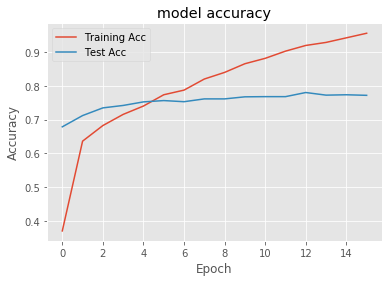

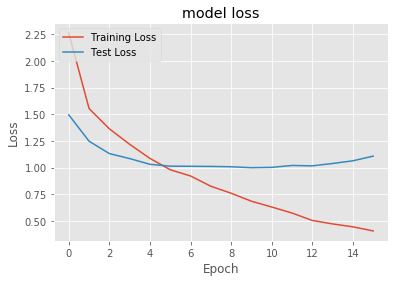

In [13]:
plt.style.use("ggplot")

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

# plt.figure()
# N = epochs
# plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="upper left")

In [14]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  1.1219440686702729
Validation Accuracy:  0.77125


In [15]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

163/162 [==============================] - 32s 196ms/step
No of errors = 604/2602


Confusion Matrix
[[  32    7   18    1    5   11    0]
 [   8   81   18    4   10   13    5]
 [  14   14  148    1   58   49    0]
 [   3    2    3    8    4    9    1]
 [  17   10   42    1  143   99    0]
 [   6   21   49    3   90 1554    7]
 [   0    0    0    0    0    1   32]]


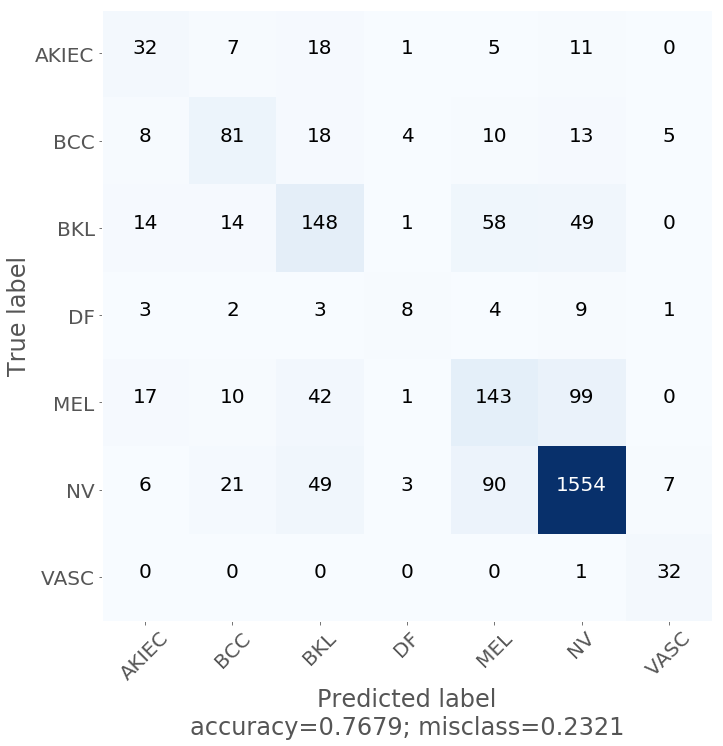

In [16]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title=' ')

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[  32    7   18    1    5   11    0]
 [   8   81   18    4   10   13    5]
 [  14   14  148    1   58   49    0]
 [   3    2    3    8    4    9    1]
 [  17   10   42    1  143   99    0]
 [   6   21   49    3   90 1554    7]
 [   0    0    0    0    0    1   32]]
              precision    recall  f1-score   support

          NV       0.40      0.43      0.42        74
          DF       0.60      0.58      0.59       139
         BKL       0.53      0.52      0.53       284
       AKIEC       0.44      0.27      0.33        30
         BCC       0.46      0.46      0.46       312
         MEL       0.90      0.90      0.90      1730
        VASC       0.71      0.97      0.82        33

   micro avg       0.77      0.77      0.77      2602
   macro avg       0.58      0.59      0.58      2602
weighted avg       0.77      0.77      0.77      2602



In [18]:
total= sum(sum(cm))

accuracy = (cm[0,0] + cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  4.342813220599539
Sensitivity :  80.0
Specificity :  92.04545454545455


In [ ]:
# # ROC Curve for each class
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# import matplotlib.pyplot as plt
# %matplotlib inline  
# from scipy import interp
# from itertools import cycle


# y_pred = predicts
# y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
# y_actual = validation_generator.classes

# classnames=[]
# for classname in validation_generator.class_indices:
#     classnames.append(classname)

# y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4,5,6])
# y_pred_binary = y_pred_probabilities#label_binarize(y_pred_probabilities, classes=[0, 1, 2, 3, 4])
# n_classes=7
# lw=2

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# # Compute macro-average ROC curve and ROC area

# # First aggregate all false positive rates
# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# # Then interpolate all ROC curves at this points
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(n_classes):
#     mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# # Finally average it and compute AUC
# mean_tpr /= n_classes

# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# # Plot all ROC curves
# plt.figure(figsize=(7, 7))


# colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(classnames[i], roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic for multi-class')
# plt.legend(loc="best")
# plt.show()

In [ ]:
# # Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)

# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=6)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=6)


# colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(classnames[i], roc_auc[i]))

    
    
# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic for multi-classs')
# plt.legend(loc="lower right")
# plt.savefig('plots/5.VGG19-ROC.png', dpi = 100)
# plt.show()

In [19]:
model.save('models/14.NASNetLarge-ImageNetMean-without-augment-Model.h5')
model.save_weights('models/14.NASNetLarge-ImageNetMean-without-augment-Weights.h5')

___